In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#from piecewise import *
from piecewiseUnet import *
import time
import corner as corner

/home/claudius/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Settings

In [2]:
NP_DTYPE = np.float32

## Testing

In [3]:
tf.enable_eager_execution()

In [4]:
test = PiecewiseLinear(10,5,32)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          1536        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
_____________________________________

In [5]:
val = np.array(np.random.rand(10,10),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))

True


In [6]:
backward = test.inverse(val)
inverseback = test.forward(backward)
print(np.allclose(val,inverseback.numpy()))

True


In [7]:
print(np.allclose(test.forward_log_det_jacobian(val,event_ndims=1),-test.inverse_log_det_jacobian(forward,event_ndims=1),atol=1e-6))
print((test.forward_log_det_jacobian(val,event_ndims=1)))
print(test.inverse_log_det_jacobian(forward,event_ndims=1))

True
tf.Tensor(
[ 0.01818122 -0.02101295 -0.17654996  0.05674268 -0.0464559   0.08625549
  0.04668082  0.13422294 -0.06405003 -0.15159336], shape=(10,), dtype=float32)
tf.Tensor(
[-0.01818122  0.02101295  0.17654996 -0.05674268  0.0464559  -0.08625549
 -0.04668082 -0.13422294  0.06405003  0.15159336], shape=(10,), dtype=float32)


In [8]:
print(test.forward_log_det_jacobian(val,event_ndims=1))
print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *")
print(test.inverse_log_det_jacobian(forward,event_ndims=1))
print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *")
print(test.forward_log_det_jacobian(val,event_ndims=1)+test.inverse_log_det_jacobian(forward,event_ndims=1))

tf.Tensor(
[-0.00185724  0.01149693 -0.00409825 ...  0.00069544  0.00692432
  0.00657224], shape=(10000,), dtype=float32)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
tf.Tensor(
[ 0.00185736 -0.01149681  0.00409855 ... -0.00069538 -0.00692432
 -0.00657224], shape=(10000,), dtype=float32)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
tf.Tensor(
[1.1920929e-07 1.1920929e-07 2.9802322e-07 ... 5.9371814e-08 0.0000000e+00
 4.6566129e-10], shape=(10000,), dtype=float32)


In [36]:
myval=np.array(np.random.rand(1,10),dtype=NP_DTYPE)
print(myval)
print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *")
print(test.forward_log_det_jacobian(myval,event_ndims=1))
print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *")
print(test.inverse_log_det_jacobian(test.forward(myval),event_ndims=1))
print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *")
print(test.forward_log_det_jacobian(myval,event_ndims=1)+test.inverse_log_det_jacobian(test.forward(myval),event_ndims=1))

[[0.71853775 0.8207269  0.5863848  0.03576051 0.3718208  0.3225138
  0.8302267  0.6243548  0.14475797 0.3131701 ]]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
tf.Tensor([0.08400674], shape=(1,), dtype=float32)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
tf.Tensor([-0.08400662], shape=(1,), dtype=float32)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
tf.Tensor([1.1920929e-07], shape=(1,), dtype=float32)


In [8]:
test = PiecewiseQuadratic(6,3,5)

In [10]:
val = np.array(np.random.rand(1000,10),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])

True
[]


In [9]:
tf.disable_eager_execution()

## Training

In [3]:
sess = tf.InteractiveSession()

In [4]:
bijectors = []

for i in range(1):
    bijectors.append(PiecewiseLinear(2,1,10,layer_id=i))
#    bijectors.append(tfb.Permute(permutation=[5,6,7,8,9,0,1,2,3,4]))
    #bijectors.append(tfb.Permute(permutation=[1,2,3,4,5,0]))
    #bijectors.append(tfb.Permute(permutation=[1,0]))
#bijectors.append(tfb.Permute(permutation=[2,3,4,5,0,1]))

# Discard the last Permute layer
#test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
test_bijector = tfb.Chain(list(reversed(bijectors[:])))
test_bijector.forward_min_event_ndims

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          512         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
_____________________________________

1

In [5]:
#base_dist = tfd.Uniform(low=[0.0,0.0,0.0,0.0,0.0,0.0],high=[1.0,1.0,1.0,1.0,1.0,1.0])
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
base_dist = tfd.Independent(distribution=base_dist,
                           reinterpreted_batch_ndims=1,
                           )
#base_dist = tfd.MultivariateNormalDiag(loc=[0., 0.])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
)

#base_dist
#dist

In [6]:
x = base_dist.sample(5000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

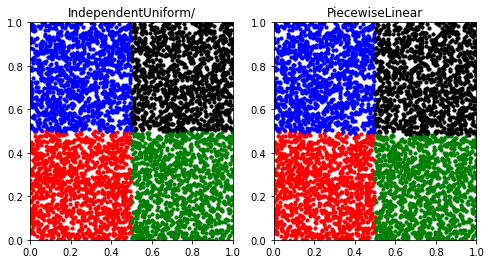

In [7]:
sess.run(tf.global_variables_initializer())
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [10]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[array([[ 0.0102731 ,  0.24572057,  0.19651794, -0.39868712,  0.51359314,
        -0.340806  , -0.28926644,  0.4578753 , -0.4250893 , -0.11412248,
        -0.22334412,  0.16999477,  0.20329803, -0.37390846, -0.42098242,
         0.32280385],
       [ 0.12699217,  0.36743742, -0.49127454, -0.27628475, -0.01055104,
         0.08596277,  0.0759747 ,  0.33264792,  0.10159183, -0.37775946,
        -0.08066091,  0.4319889 ,  0.36289418, -0.00549841,  0.08122164,
        -0.1842795 ],
       [-0.43005118, -0.07361513, -0.00355762, -0.42520437,  0.40820986,
        -0.3229588 ,  0.33167368,  0.2830103 ,  0.1393106 ,  0.02358574,
         0.27847314,  0.14320785,  0.11603558,  0.49382502,  0.05435449,
         0.26285106],
       [ 0.5211236 ,  0.04208732,  0.20233959, -0.33065286,  0.3918537 ,
         0.0847739 ,  0.23927104,  0.2047534 ,  0.4484465 ,  0.2925586 ,
        -0.29442763, -0.15216908, -0.2933597 , -0.31966394, -0.25165263,
         0.4157632 ],
       [-0.31099474, -0.43313354,  

In [8]:
def step(x,x0,k=50):
    return tf.abs(0.5+0.5*tf.tanh(k*(x0-x)))

def step_np(x,x0,k=50):
    return np.abs(0.5+0.5*np.tanh(k*(x0-x)))

def dsigmaTrain(x):
    #return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))
    return (x[:,0]**2+x[:,1]**2)/((1-x[:,0])*(1-x[:,1]))*step(x[:,0],0.9)*step(x[:,1],0.9)

def dsigmaCircle(x):
    return (x[:,0]**2+x[:,1]**2)/((1.-x[:,0])*(1.-x[:,1]))*step(tf.sqrt(x[:,0]**2+x[:,1]**2),0.95)+1e-6

def dsigmaCircle_np(x):
    x0,x1=x
    return (x0**2+x1**2)/((1.-x0)*(1.-x1))*step_np(np.sqrt(x0**2+x1**2),0.95)+1e-6

def dsigmaTrue(x):
    return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))

def dsigmaTest(x):
    return 10**7*(1+(2*x[:,0]-1)**2)/((90**2-(90*2*(1-x[:,1]))**2)**2+2.5**2*90**2)

def normalChristina(x):
    return 0.8* tf.exp((-0.5*((x[:,0]-0.5)* (50 *(x[:,0]-0.5) -  15* (x[:,1]-0.5)) + (-15*(x[:,0]-0.5) + 5*(x[:,1]-0.5))* (x[:,1]-0.5))))
def normalChristina_np(x1,x2):
    return 0.8* np.exp((-0.5*((x1-0.5)* (50 *(x1-0.5) -  15* (x2-0.5)) + (-15*(x1-0.5) + 5*(x2-0.5))* (x2-0.5))))

def camel(x):
    return 8* tf.exp((-0.5*(2)*(( (x[:,0]-0.25)* (25.0 *(x[:,0]-0.25) -  15* (x[:,1]-0.25)) + (-15*(x[:,0]-0.25) + 5*(x[:,1]-0.25))* (x[:,1]-0.25))+((x[:,0]-0.75)* (25 *(x[:,0]-0.75) -  15* (x[:,1]-0.75)) + (-15*(x[:,0]-0.75) + 5*(x[:,1]-0.75))* (x[:,1]-0.75)))))+1e-6
def camel_np(x0,x1):
    return 8* np.exp((-0.5*(2)*(( (x0-0.25)* (25.0 *(x0-0.25) -  15* (x1-0.25)) + (-15*(x0-0.25) + 5*(x1-0.25))* (x1-0.25))+((x0-0.75)* (25 *(x0-0.75) -  15* (x1-0.75)) + (-15*(x0-0.75) + 5*(x1-0.75))* (x1-0.75)))))+1e-6

def MultiGauss(x):
    return  tf.exp(-4.*((x[:,0]-0.5)**2 + (x[:,1]-0.5)**2+4*(x[:,1]-0.5)*(x[:,0]-0.5)+(x[:,2]-0.75)**2 + (x[:,3]-0.5)**2+(x[:,4]-0.5)**2 -(x[:,4]-0.5)*(x[:,5]-0.5)+ (x[:,5]-0.5)**2-8*(x[:,3]-0.5)*(x[:,5]-0.5)))+1e-6
    
def MultiGauss_np(x):
    x0,x1,x2,x3,x4,x5 = x
    return np.exp(-4.*((x0-0.5)**2 + (x1-0.5)**2+4*(x1-0.5)*(x0-0.5)+(x2-0.75)**2 + (x3-0.5)**2+(x4-0.5)**2 + (x5-0.5)**2-(x4-0.5)*(x5-0.5)-8*(x3-0.5)*(x5-0.5)))+1e-6

def MultiGauss2(x):
    return  tf.exp(-4.*((x[:,0]-0.5)**2 + (x[:,1]-0.5)**2+4*(x[:,1]-0.5)*(x[:,0]-0.5)   ))+1e-6#+(x[:,2]-0.75)**2 + (x[:,3]-0.5)**2))+1e-6
    
def MultiGauss_np2(x):
    x0,x1 = x
    return np.exp(-4.*((x0-0.5)**2 + (x1-0.5)**2+4*(x1-0.5)*(x0-0.5)   ))+1e-6#+(x2-0.75)**2 + (x3-0.5)**2))+1e-6

def Wall10(x):
    return 1e3*tf.exp(-2.*(x[:,0]+x[:,1]+x[:,2]+x[:,3]+x[:,4]+x[:,5]+x[:,6]+x[:,7]+x[:,8]+x[:,9]-1.)**2) +1e-6
def Wall10_np(x):
    x0,x1,x2,x3,x4,x5,x6,x7,x8,x9 = x
    return 1e3*np.exp(-2.*(x0+x1+x2+x3+x4+x5+x6+x7+x8+x9-1.)**2)+1e-6

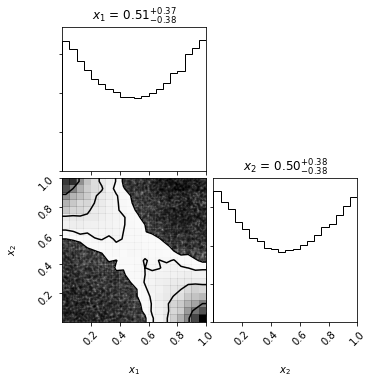

In [11]:
x = dist.sample(100000)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = MultiGauss2(x)
#dsig = Wall10(x)
#dsig = normalChristina(x)
xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

figure = corner.corner(xPts, labels=[r"$x_1$", r"$x_2$",r"$x_3$",r"$x_4$",r"$x_5$",r"$x_6$"],
                       weights=dsigPts/qPts,
                       #weights=1./qPts,
                       show_titles=True, title_kwargs={"fontsize": 12})
#plt.savefig("MultiGauss-4dim-target.pdf",bbox_inches='tight',dpi=150)

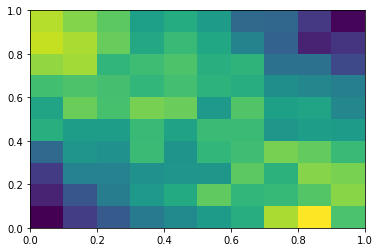

In [11]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

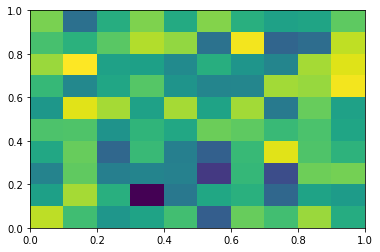

In [13]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=1./qPts,norm=mpl.colors.LogNorm())
plt.show()

In [9]:
def loss_fn(func):
    x = dist.sample(500)
    logq = dist.log_prob(x)
    p = func(x)
    q = dist.prob(x)
    p = p/tf.reduce_mean(p/q)
    return tf.reduce_mean(p/q*(tf.log(p)-logq))

In [337]:
def grad():
    with tf.GradientTape() as tape:
        loss_value = loss_fn()
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [12]:
def loss_grad():
    with tf.GradientTape() as tape:
        x = dist.sample(1000)
        logq = dist.log_prob(x)
        p = dsigmaTest(x)
        q = tf.stop_gradient(tf.exp(logq))
        loss = tf.reduce_mean(p/q*(tf.log(p)-logq))
    grad = tape.gradient(loss,bijector.trainable_variables)
    return loss, grad

In [10]:
loss = loss_fn(MultiGauss2)
optimizer = tf.train.AdamOptimizer(1e-4)
grads = optimizer.compute_gradients(loss)
opt_op = optimizer.apply_gradients(grads)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


(0, 0.44672972)
(100, 0.31515408)
(200, 0.055630397)
(247, 0.039368264)
Done
--- 0.0 hours, 0.0 minutes and 6.95 seconds ---


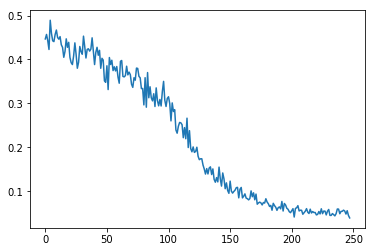

In [11]:
start_time = time.time()
np_losses = []
global_step = []
for epoch in range(2000):
    _, np_loss, np_grads = sess.run([opt_op, loss, grads])
    global_step.append(epoch)
    np_losses.append(np_loss)
    #print(np_x,np_logq)
    if(np_loss != np_loss):
        print(epoch, np_loss)
        break
    if (np_loss < 0.04):
        break
    if epoch % 100 == 0:
        print(epoch, np_loss)
print(epoch, np_loss)
start = 0
plt.plot(np_losses[start:])
Time = time.time() - start_time
Hours = Time//3600
Minutes = (Time - 3600*Hours)//60
Seconds = (Time - 3600*Hours - 60*Minutes)
print("Done")
print("--- %(STD)s hours, %(MIN)s minutes and %(SEC).2f seconds ---" %{'STD':Hours,'MIN':Minutes, 'SEC':Seconds})

In [1]:
#plt.plot(np_losses[start:])
#plt.savefig("MultiGauss-4dim-loss.pdf",bbox_inches='tight',dpi=150)

In [18]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[[array([[ 0.07150314,  0.20173413, -0.18514825, -0.08732727,  0.00835978,
        -0.08146924,  0.12202232,  0.1268221 , -0.05403043, -0.10278017,
        -0.06680442,  0.20785235, -0.04518585,  0.0374806 ,  0.04260312,
         0.084534  , -0.19761024,  0.02620223, -0.01916718, -0.07196656,
        -0.21375607, -0.03822294,  0.16568899, -0.08736865,  0.04125881,
        -0.20205426,  0.04863051,  0.00146476,  0.20414372,  0.05762893,
         0.01918037,  0.05884843,  0.13274145,  0.19372758, -0.21135204,
         0.0475045 ,  0.09351382, -0.21289593, -0.21401912, -0.17104211,
        -0.08225615, -0.15021348,  0.20807004,  0.15486242,  0.03590831,
         0.09489552, -0.18654047, -0.15390643, -0.02289134, -0.03930269,
         0.16968867,  0.12500535,  0.16881047, -0.135131  ,  0.10072897,
        -0.17893478,  0.14550844, -0.20477743,  0.19047405, -0.0245211 ,
        -0.02554336,  0.1062631 ,  0.10989171,  0.16190788, -0.01302949,
        -0.19350858, -0.17928077, -0.16797957, -0

[[array([[-0.02649923, -0.00038224,  0.20229638,  0.06748655, -0.06300093,
         0.20439166,  0.11433432,  0.0698548 , -0.21046948, -0.00129405,
         0.16397369,  0.02274439, -0.09708282, -0.02482201, -0.14490822,
         0.04331693,  0.11589399, -0.12123649,  0.02951437,  0.02790955,
         0.1574843 , -0.10684461,  0.154463  ,  0.05603364, -0.04402287,
         0.16415232, -0.08887975,  0.10258123, -0.06715614,  0.0517714 ,
         0.19881514, -0.10389431,  0.17552176, -0.149989  ,  0.1632328 ,
         0.21155581,  0.13928938, -0.00821728, -0.07661475,  0.08281672,
         0.11191276,  0.17382231, -0.1722142 , -0.14423633, -0.19779503,
         0.13796031, -0.08650009,  0.14837122, -0.05461779,  0.09687072,
        -0.16436756, -0.09936566, -0.0181566 ,  0.11465505, -0.1472241 ,
        -0.21351486,  0.0037405 ,  0.03836203,  0.01675498,  0.02240337,
        -0.06900463,  0.08580127, -0.10074919,  0.11973086,  0.00531644,
        -0.10942521, -0.16193905, -0.05004729,  0

[[array([[ 0.08657715, -0.1748874 , -0.1430958 ,  0.05185094,  0.10279441,
        -0.0850109 ,  0.17267011, -0.15154512, -0.12114126,  0.04127121,
         0.04585348, -0.078869  ,  0.09433834,  0.13832782,  0.03260768,
         0.14404665, -0.13425544,  0.04318652,  0.05431624,  0.06458542,
         0.01171916,  0.03999133,  0.04454229, -0.13121305,  0.17517118,
         0.10046284, -0.02209482,  0.03600176,  0.0951236 ,  0.14456241,
        -0.05224955, -0.12196273,  0.1370048 , -0.06584191, -0.04573871,
        -0.19279411,  0.07724045,  0.03741796, -0.00216781,  0.17189956,
        -0.02439091,  0.11330733, -0.1746205 ,  0.19226559, -0.11799141,
        -0.2082914 ,  0.0088076 ,  0.11104309,  0.13163969,  0.00949745,
        -0.11568646, -0.20209956, -0.21213186,  0.14388673,  0.12721461,
        -0.01919413, -0.08082151,  0.08126871, -0.2109611 , -0.01984879,
         0.0718528 ,  0.10813347,  0.00488368,  0.20860384, -0.07687627,
         0.15564995, -0.15891564, -0.19774759, -0

[[array([[ 1.71833396e-01, -6.17321730e-02,  1.41291484e-01,
         3.28436904e-02,  4.93970029e-02, -1.37631595e-01,
        -1.20512515e-01, -1.58928081e-01,  6.15600385e-02,
         1.80975661e-01, -5.08883893e-02, -1.81214571e-01,
        -1.67380124e-01,  8.57118741e-02,  6.66679665e-02,
        -4.20884490e-02,  1.30661383e-01, -1.35494173e-01,
         6.55026510e-02, -1.43592566e-01,  5.47132902e-02,
         7.36898184e-02, -1.96374342e-01, -5.14133722e-02,
        -4.52219993e-02,  1.00739554e-01,  1.73104346e-01,
         1.04865395e-02, -9.00219679e-02,  3.66168246e-02,
         1.37060076e-01, -3.47850919e-02,  1.08805642e-01,
        -1.47359550e-01, -1.39680535e-01,  6.07076772e-02,
         1.68237209e-01, -2.06100747e-01,  1.74760565e-01,
         7.65139684e-02, -1.04543313e-01,  6.75735176e-02,
         5.39307483e-02, -1.15752690e-01, -1.25806019e-01,
        -1.44577026e-01, -1.49541497e-02,  6.72810385e-03,
        -1.24270298e-01,  2.23551411e-02, -1.97076470e

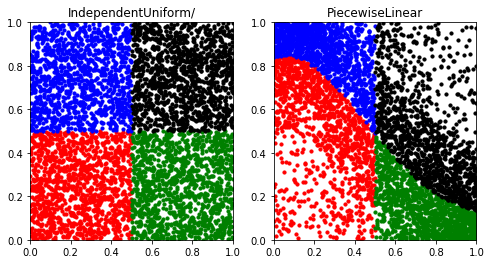

In [12]:
x = base_dist.sample(5000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])
    


In [13]:
nsamples = 100000
x = dist.sample(nsamples)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = MultiGauss2(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])
"""
print(xPts)
print(logqPts)
print(qPts)
print(dsigPts)
"""
#plt.scatter(xPts[:,0],xPts[:,1],s=1)
#plt.show()


'\nprint(xPts)\nprint(logqPts)\nprint(qPts)\nprint(dsigPts)\n'

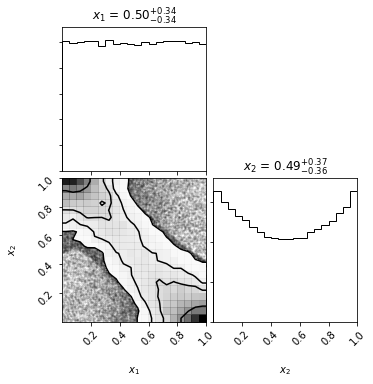

In [14]:
figure = corner.corner(xPts, labels=[r"$x_1$", r"$x_2$",r"$x_3$",r"$x_4$",r"$x_5$",r"$x_6$"],
                       #weights=dsigPts/qPts,
                       #weights=1./qPts,
                       show_titles=True, title_kwargs={"fontsize": 12})
plt.savefig("MultiGauss-6dim-sample.pdf",bbox_inches='tight',dpi=150)

[0.7678391 0.6169162]


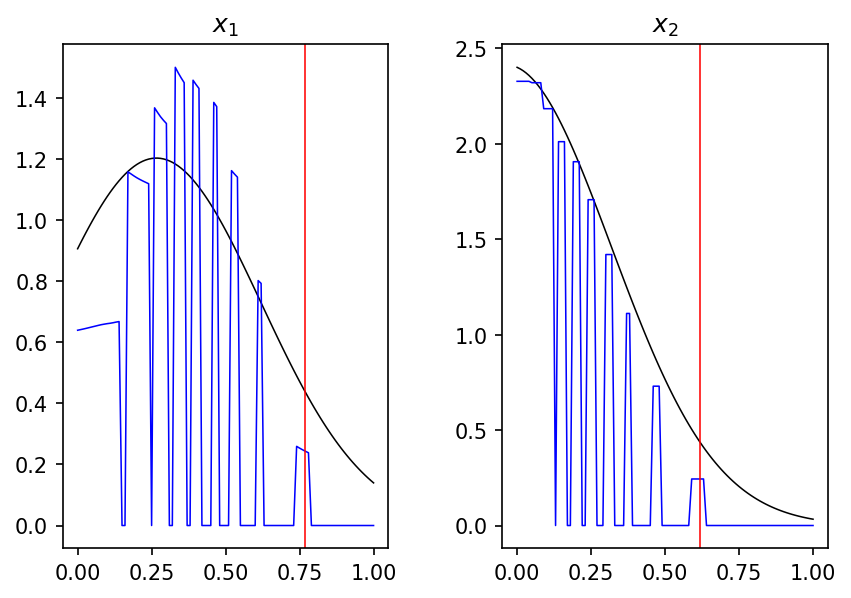

* * * Done part I * * *


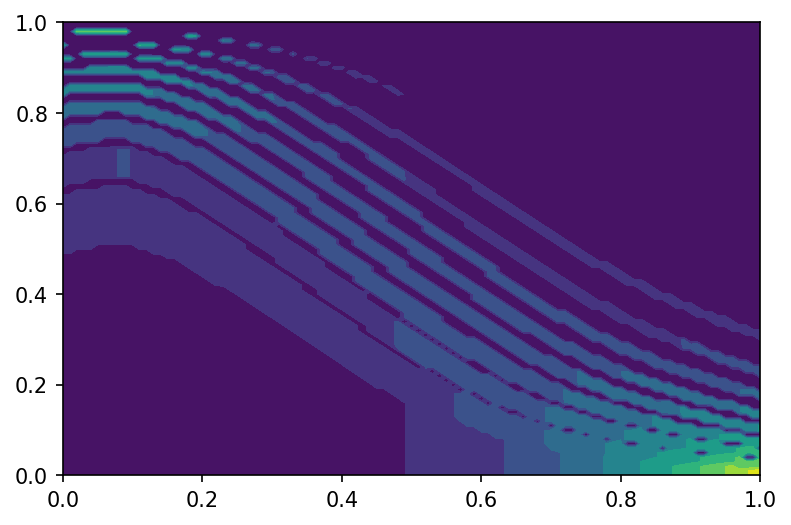

In [17]:
numpoints=101
ndim=2
x_axis=np.linspace(0.,1.,numpoints, endpoint=True)
y_axis=np.linspace(0.,1.,numpoints, endpoint=True)



#integral_value=3.531
integral_value=0.98

x_array = np.array([],dtype=NP_DTYPE)
true_array = np.array([],dtype=NP_DTYPE)
plt.figure(dpi=150,figsize=[6.,4.])

#ran=np.random.rand(6)

ran=np.array(sess.run(dist.sample(1))).flatten()
print(ran)
for j in range(ndim): 
    pos=np.copy(ran)
    for i in x_axis:
        pos[j]=i
        #x_array.append([i,ran[1],ran[2],ran[3],ran[4],ran[5]])
        #x_array.append(np.copy(pos))
        x_array=np.concatenate((x_array,np.copy(pos)))
x_array=x_array.reshape((-1,ndim))
for i in range(len(x_array)):
    true_array=np.concatenate((true_array,[MultiGauss_np2(x_array[i])/integral_value]))
    #    true_array.append(MultiGauss_np(x_array[i])/integral_value)
true_array = true_array.reshape((-1,numpoints))
x=dist.prob(x_array)
#print(x_array[numpoints:])
#x=bijectors[0].forward(x_array[numpoints:])
xPts= np.array(sess.run([x]))
xPts= xPts.reshape((-1,numpoints))
#print(xPts)
#print(ran)
for j in range(ndim): 
    #ax=plt.subplot(2,3,j+1)
    ax=plt.subplot(1,2,j+1)
    ax.set_title(r'$x_{%(dim)i}$' %{'dim':j+1})
    plt.plot(x_axis,true_array[j],'k',lw=0.75)
    plt.plot(x_axis,xPts[j],'b',lw=0.75)
    plt.axvline(x=ran[j],color='r',lw=0.75)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=.35)
plt.show()
print("* * * Done part I * * *")
plt.figure(dpi=150,figsize=[6.,4.])
x_array2 = np.array([],dtype=NP_DTYPE)

for xi in x_axis:
    for yi in y_axis:
        x_array2=np.concatenate((x_array2,np.array([yi,xi])))
x_array2 = x_array2.reshape((-1,2))
x2=dist.prob(x_array2)
xPts2= np.array(sess.run([x2]))
xPts2= xPts2.reshape((-1,numpoints))
X,Y=np.meshgrid(x_axis,y_axis)
plt.contourf(X,Y,xPts2,10)
plt.show()
#plt.plot(x_axis,true_array,"k")
#plt.plot(x_axis,xPts[0],"b")

In [13]:

#test=dist.prob(ran_tf)
#test_log=dist.log_prob(ran_tf)

#array=np.array([[0.0,0.0,0.0,0.0,0.0,0.0],ran],dtype=NP_DTYPE)
ran=np.random.rand(6)

array=np.array([[0.,0.,0.,0.,0.,0.],ran],dtype=NP_DTYPE)
ran_tf=tf.random.uniform((1,6),minval=0.,maxval=1.)
zero=tf.constant(0.1, shape=(1,6))
array_sam=dist.sample(1)
#array_sam=0.1* array_sam/array_sam

prob_ar=dist.prob(array)
prob_zero=dist.prob(zero)
prob_tf=dist.prob(ran_tf)
prob_sam=dist.prob(array_sam)

log_ar=dist.log_prob(array)
log_zero=dist.log_prob(zero)
log_tf=dist.log_prob(ran_tf)
log_sam=dist.log_prob(array_sam)

#test=dist.prob(np.array([ran],dtype=NP_DTYPE))
#test_log=dist.log_prob(np.array([ran],dtype=NP_DTYPE))
#print(ran)
print("* * *")
#print(sess.run([array,prob_ar,log_ar]))
print(sess.run([ran_tf,prob_tf,log_tf]))
print("* * *")
print(sess.run([zero,prob_zero,log_zero]))
print("* * *")
print(sess.run([array_sam,prob_sam,log_sam]))
print("* * *")
print(ran_tf)
print(array_sam)

* * *
[array([[0.9277749, 0.8641764, 0.6606431, 0.6717371, 0.3471607, 0.3048135]],
      dtype=float32), array([0.], dtype=float32), array([-inf], dtype=float32)]
* * *
[array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([0.], dtype=float32), array([-inf], dtype=float32)]
* * *
[array([[0.05961005, 0.92147535, 0.39703032, 0.9796316 , 0.44959155,
        0.9274943 ]], dtype=float32), array([79.340546], dtype=float32), array([4.3737493], dtype=float32)]
* * *
Tensor("random_uniform:0", shape=(1, 6), dtype=float32)
Tensor("chain_of_permute_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinearIndependentUniform/sample_2/chain_of_permute_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear/forward/permute_4/forward/GatherV2:0", shape=(1, 6), dtype=float32)


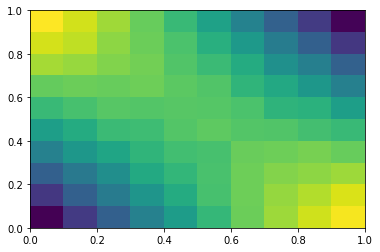

In [17]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

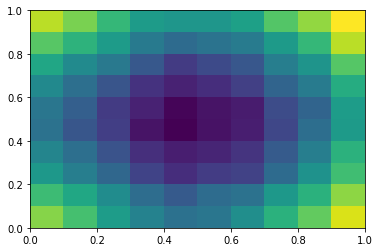

In [16]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [21]:
start_time = time.time()
import vegas

ndims = 2
#integ = vegas.Integrator([[0.,1.],[0.,1.],[0.,1.],[0.,1.],[0.,1.],[0.,1.],[0.,1.],[0.,1.],[0.,1.],[0.,1.]])
integ = vegas.Integrator(ndims*[[0.,1.]])
#result = integ(Wall10_np, nitn=10, neval=400200)
integ(MultiGauss_np2, nitn=10, neval=200000)#,max_nhcube=1)
result = integ(MultiGauss_np2, nitn=5, neval=25000)#,max_nhcube=1)
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))
Time = time.time() - start_time
Hours = Time//3600
Minutes = (Time - 3600*Hours)//60
Seconds = (Time - 3600*Hours - 60*Minutes)
print("Done")
print("--- %(STD)s hours, %(MIN)s minutes and %(SEC).2f seconds ---" %{'STD':Hours,'MIN':Minutes, 'SEC':Seconds})

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.98183(22)     0.98183(22)         0.00     1.00
  2   0.98189(26)     0.98185(17)         0.03     0.87
  3   0.98216(28)     0.98194(14)         0.45     0.64
  4   0.98204(28)     0.98196(13)         0.34     0.80
  5   0.98281(28)     0.98210(12)         2.15     0.07

result = 0.98210(12)    Q = 0.07
Done
--- 0.0 hours, 0.0 minutes and 8.30 seconds ---


In [16]:
start_time = time.time()
nsamples = 25000
nitn=5
xsec=0.
invvar=0.
for i in range(nitn):
    x = dist.sample(nsamples)
    q = dist.prob(x)
    dsig = MultiGauss(x)
    mean, var = sess.run(tf.nn.moments(dsig/q,axes=[0]))
    xsec+=mean*nsamples/var
    invvar+=(nsamples/var)

xsec=xsec/invvar
var=1./invvar
stddev=np.sqrt(var)
#print('xsec = %.4f, var = %.4f, stddev = %.4f' % (mean,var/nsamples,np.sqrt(var/nsamples)))
print('xsec = %e, var = %e, stddev = %e' % (xsec,var,stddev))

Time = time.time() - start_time
Hours = Time//3600
Minutes = (Time - 3600*Hours)//60
Seconds = (Time - 3600*Hours - 60*Minutes)
print("--- %(STD)s hours, %(MIN)s minutes and %(SEC).2f seconds ---" %{'STD':Hours,'MIN':Minutes, 'SEC':Seconds})

xsec = 3.528633e+00, var = 5.098651e-06, stddev = 2.258019e-03
--- 0.0 hours, 0.0 minutes and 20.42 seconds ---
